** Notes **
* Be very careful when constructing the resolution matrix. If missed by a transpose, the result will be wrong!!

In [1]:
# %cd ~/dev/graphite-DOS/irradiated-notebooks/

In [2]:
from __future__ import (absolute_import, division, print_function)

import os, sys
import numpy as np
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H
from scipy.interpolate import interp1d
import warnings
from numpy import linalg as LA

In [3]:
# %matplotlib notebook
%matplotlib inline

In [4]:
sys.path.insert(0, '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/')
sys.path.append('/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres')

In [5]:
# sys.path.insert(0, '/home/lj7/dv/srins/srins/')
# sys.path.insert(0, '/SNS/users/lj7/dv/srins/srins-jiao/')

In [6]:
import srins

In [7]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.pyc
import srins.powder.linearizedBregman as splb; reload(splb)
import srins.powder.conv_deconv as spcd
import srins.powder.Lucy_Richardson as LR; reload(LR)
import srins.powder.bregmanSplit as spbs; 
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc
reload(spbs)

!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.pyc
reload(LR)

<module 'srins.powder.Lucy_Richardson' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.py'>

In [8]:
from srins.powder.conv_deconv import convolve_NS as F

In [9]:
import srins.powder.linearizedBregman as splb; reload(splb)

<module 'srins.powder.linearizedBregman' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.pyc'>

In [10]:
Eaxis = np.arange(-50, 240, 0.1)

In [11]:
res_mat1=np.load ('res_matrix_Ei_300.npy')

In [12]:
doshist = hh.load('final-dos.h5')
g = doshist.I

In [13]:
E = doshist.E

In [14]:
g1 = np.interp(Eaxis, E, g)

## Linearized Bregman

In [15]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.pyc
import srins.powder.linearizedBregman as splb; reload(splb)

<module 'srins.powder.linearizedBregman' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/linearizedBregman.py'>

In [16]:
 Error=doshist.E2

In [17]:
value=np.nanmean(Error**.5)

In [18]:
RF_T = np.transpose(res_mat1)
m = F(RF_T, res_mat1)
max_delta = 2. / LA.norm(m, ord=1)
print (max_delta)

1.95942980415


In [19]:
delta = max_delta * .8

In [20]:
ini_uZ = np.zeros(Eaxis.shape[0])
ini_vZ = np.zeros(Eaxis.shape[0])
neu_N = np.linalg.norm(g1, 2)**2 / 2/delta/np.linalg.norm(g1,1)
print(neu_N)

0.00189252190848


In [21]:
RV, RU, error, it, errorBL = splb.bregman_NS(g1, res_mat1, ini_vZ, ini_uZ, neu_N, delta, 'errorModel', value, maxIter=100)

In [22]:
print ('no of iteration for Bregman linearized: ', it)

no of iteration for Bregman linearized:  7


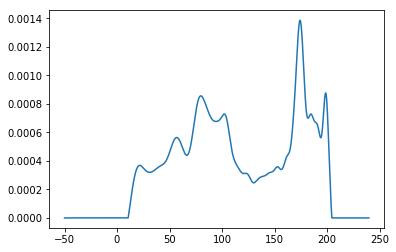

In [23]:
plt.figure()
plt.plot(Eaxis, RU/RU.sum())
# plt.plot(Eaxis, y3/y3.sum())
plt.show()
# plt.plot(Eaxis,y_delta/y_delta.sum())

# Bregman Split

In [24]:
reload (spbs)

<module 'srins.powder.bregmanSplit' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/bregmanSplit.pyc'>

In [25]:
recSplit, itS= spbs.split_Bregman(g1, res_mat1, ini_vZ, ini_uZ, neu_N, delta, value, 100)

In [26]:
print (itS)

5


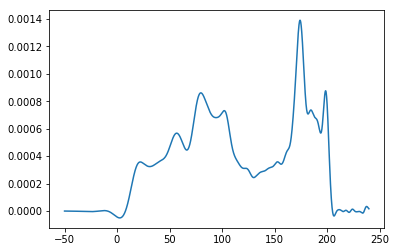

In [27]:
plt.figure()
plt.plot(Eaxis, recSplit/np.sum(recSplit))
plt.show()

# Lucy Richardson

In [28]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.pyc
reload(LR)

<module 'srins.powder.Lucy_Richardson' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Lucy_Richardson.py'>

In [29]:
ini1=(np.sum(g1,0)/len(g1)) * np.ones(len(g1))#initial guess
R,E,EB,In=LR.deconvolve_NS(g1, res_mat1, ini1, 'errorModel', value,maxIter=100)

In [30]:
print ('no of iteration for Lucy Richardson: ', In)

no of iteration for Lucy Richardson:  10


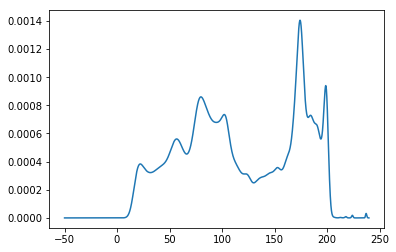

In [31]:
plt.figure()
plt.plot(Eaxis, R/R.sum())
# plt.plot(y_delta/y_delta.sum())
plt.show()

# regularized Lucy Richardson 

In [32]:
!rm /home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Regularized_LucyRichardson_L1norm.pyc
import srins.powder.Regularized_LucyRichardson_L1norm as L1lr
reload(L1lr)

<module 'srins.powder.Regularized_LucyRichardson_L1norm' from '/home/fi0/dev/sandbox/SR-INS/1D/dev/srins/srins/powder/Regularized_LucyRichardson_L1norm.pyc'>

In [33]:
r1,E1,EB1,In1=L1lr.deconvolve_L1_NS(g1, res_mat1, ini1, 3, 0.1, 'errorModel', value, maxIter=100)

In [34]:
print ('no of iteration for regularized Lucy richardson: ', In1)

no of iteration for regularized Lucy richardson:  100


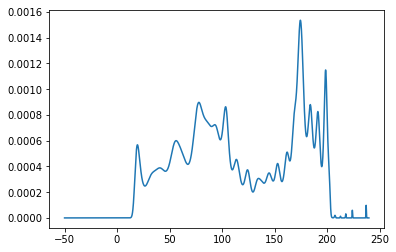

In [35]:
plt.figure()
plt.plot(Eaxis, r1/r1.sum())
# plt.plot(R/R.sum())
plt.show()

# comparison

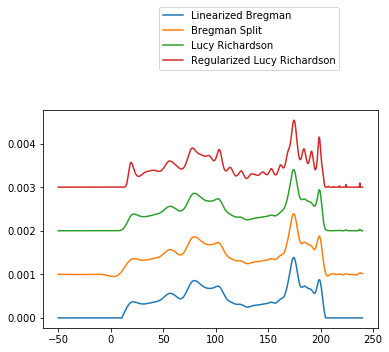

In [36]:
plt.figure()
plt.plot(Eaxis, RU/RU.sum(), label='Linearized Bregman')
plt.plot(Eaxis, recSplit/recSplit.sum()+0.001, label='Bregman Split')
plt.plot(Eaxis,R/R.sum()+0.002,label='Lucy Richardson')
plt.plot(Eaxis, r1/r1.sum()+0.003,label='Regularized Lucy Richardson')
plt.legend(loc='upper right', bbox_to_anchor=(.9, 1.5))
# plt.xlim(0,200)
plt.show()